# Exploring each type of feature
- <a href='#sec1'><b>B</b></a>
- <a href='#sec2'><b>C</b></a>
- <a href='#sec3'><b>C</b></a>

- Data Explanation from Kaggle<br>
In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
%matplotlib inline

In [2]:
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)

## Import Data and name labels

In [3]:
train = pd.read_csv('train.csv', header=0)

In [4]:
all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

In [5]:
print("# total of features: %8d" % len(all_fs))
print("# of binary features: %7d" % len(binary_fs))
print("# of categorical features: %1d" % len(categorical_fs))
print("# of other features: %8d" % len(other_fs))

# total of features:       57
# of binary features:      17
# of categorical features: 14
# of other features:       26


<a id='sec1'></a>
# Binary Features

In [6]:
binaries = train[binary_fs]
#binary_fs

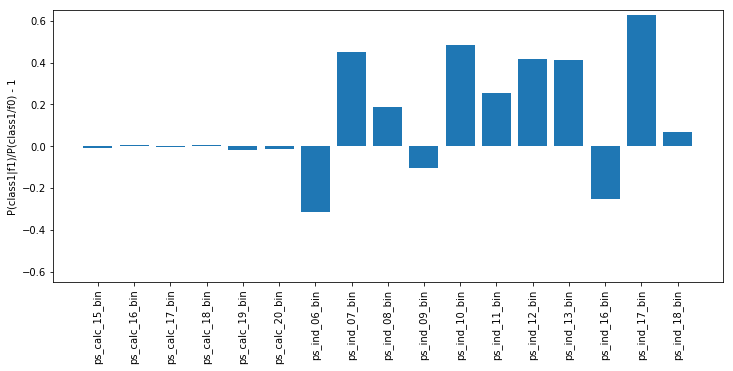

In [7]:
y = train.target
predictive_ratios = []
for i in range(len(binary_fs)):
    fs = binary_fs[i]
    x = binaries[fs]
    #print('==== %s ====' % fs)
    contingency = create_contingency_table(x,y, output=True, printout=False, percent=True)
    prob = calculate_conditional_prob_bin(contingency, output=True, printout=False)
    predictive_ratios.append(prob[1]/prob[0])

    
prob_differential = np.array(predictive_ratios) - 1

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(binary_fs, prob_differential)
ax.set_ylabel('P(class1|f1)/P(class1/f0) - 1')
ax.set_ylim([-0.65, 0.65])
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [8]:
pd.DataFrame({'features': binary_fs, 'prob_differential': prob_differential},
              columns=['features', 'prob_differential']).sort_values('prob_differential', ascending=False).head(10)

,features,prob_differential
15,ps_ind_17_bin,0.628433
10,ps_ind_10_bin,0.483333
7,ps_ind_07_bin,0.449078
12,ps_ind_12_bin,0.416948
13,ps_ind_13_bin,0.411303
11,ps_ind_11_bin,0.253854
8,ps_ind_08_bin,0.188229
16,ps_ind_18_bin,0.065642
1,ps_calc_16_bin,0.006663
3,ps_calc_18_bin,0.006289


In [9]:
useful_binary = pd.DataFrame({'features': binary_fs, 'prob_differential': prob_differential},
                      columns=['features', 'prob_differential'])\
                      .sort_values('prob_differential', ascending=False)['features'].head(5)
useful_binary = sorted(list(useful_binary))
print(useful_binary)

['ps_ind_07_bin', 'ps_ind_10_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_17_bin']


<b><i>'useful_binary' list created</i></b>

<a id='sec2'></a>
# Categorical Features

In [10]:
categoricals = train[categorical_fs]
#categorical_fs

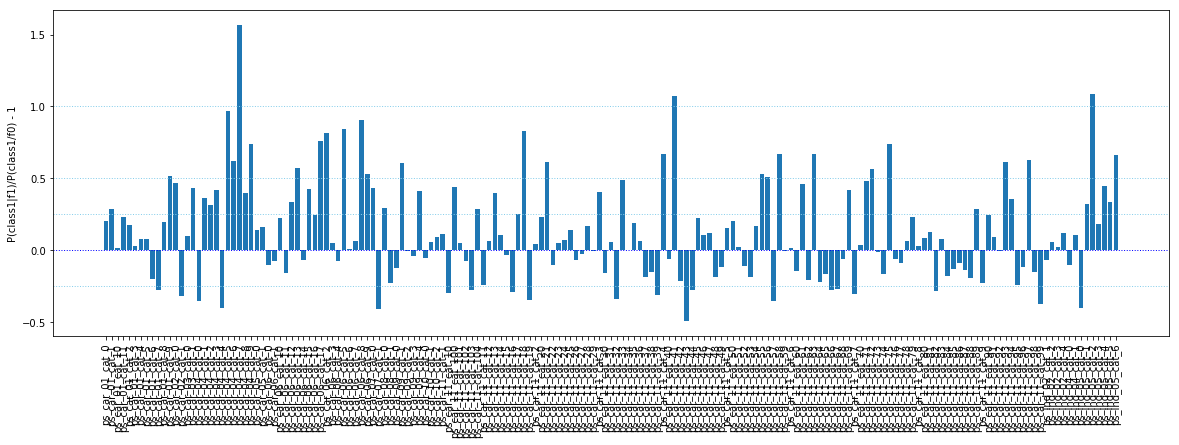

In [11]:
y = train.target
conditional_probs = pd.DataFrame()
for feature in categorical_fs:
    data = categoricals[feature]
    result = calculate_conditional_prob_cat(data, y)
    conditional_probs = pd.concat([conditional_probs, result], axis=0)

# Examine only the entries for non-NaN categories
non_NaN_inds = [ind for ind in conditional_probs.index if 'NaN' not in ind]
cat_cond_probs_noNaNs = conditional_probs.loc[non_NaN_inds, :]
cat_cond_probs_noNaNs['(f1/f0)_ratio_minus_1'] = \
            (cat_cond_probs_noNaNs.iloc[:, 1]/cat_cond_probs_noNaNs.iloc[:, 0]) -1

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.axhline(y=1, color='skyblue', ls=':', lw=1)
ax.axhline(y=0.5, color='skyblue', ls=':', lw=1)
ax.axhline(y=0.25, color='skyblue', ls=':', lw=1)
ax.axhline(y=0, color='blue', ls=':', lw=1)
ax.axhline(y=-0.25, color='skyblue', ls=':', lw=1)
ax.bar(cat_cond_probs_noNaNs.index, cat_cond_probs_noNaNs.iloc[:, -1])
ax.set_ylabel('P(class1|f1)/P(class1/f0) - 1')
#ax.set_ylim([-0.65, 0.65])
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [12]:
cat_cond_probs_noNaNs.describe(percentiles=[0.5])

,p(class1|category=0),p(class1|category=1),(f1/f0)_ratio_minus_1
count,175.000000,175.000000,175.000000
mean,0.036817,0.041320,0.130236
std,0.002854,0.012083,0.345865
min,0.033699,0.018423,-0.495916
50%,0.036431,0.038724,0.066587
max,0.058554,0.093525,1.566962


In [13]:
cutoff_dif = 0.9
cat_cond_probs_noNaNs[cat_cond_probs_noNaNs['(f1/f0)_ratio_minus_1'] >= cutoff_dif]\
        .sort_values('(f1/f0)_ratio_minus_1',ascending=False)#.head(20)

,p(class1|category=0),p(class1|category=1),(f1/f0)_ratio_minus_1
ps_car_04_cat_7,0.036434,0.093525,1.566962
ps_ind_05_cat_2,0.036171,0.075526,1.088028
ps_car_11_cat_41,0.036240,0.075110,1.072588
ps_car_04_cat_5,0.036415,0.071560,0.965096
ps_car_06_cat_8,0.036369,0.069405,0.908351


In [14]:
useful_categorical1 = cat_cond_probs_noNaNs[cat_cond_probs_noNaNs['(f1/f0)_ratio_minus_1'] >= 0.8].index
useful_categorical2 = cat_cond_probs_noNaNs[cat_cond_probs_noNaNs['(f1/f0)_ratio_minus_1'] >= 0.6].index
useful_categorical3 = cat_cond_probs_noNaNs[cat_cond_probs_noNaNs['(f1/f0)_ratio_minus_1'] >= 0.4].index
useful_categorical4 = cat_cond_probs_noNaNs[cat_cond_probs_noNaNs['(f1/f0)_ratio_minus_1'] >= 0.2].index

useful_categorical1 = sorted(list(useful_categorical1))
useful_categorical2 = sorted(list(useful_categorical2))
useful_categorical3 = sorted(list(useful_categorical3))
useful_categorical4 = sorted(list(useful_categorical4))

print('Highest Differential: %2d feature categories' % len(useful_categorical1))
print('Medium1 Differential: %2d feature categories' % len(useful_categorical2))
print('Medium2 Differential: %2d feature categories' % len(useful_categorical3))
print('Lowest  Differential: %2d feature categories' % len(useful_categorical4))

useful_categorical_neg = cat_cond_probs_noNaNs[cat_cond_probs_noNaNs['(f1/f0)_ratio_minus_1'] <= -0.3].index
useful_categorical_neg = sorted(list(useful_categorical_neg))
print('Negative Differential: %2d feature categories' % len(useful_categorical_neg))

Highest Differential:  8 feature categories
Medium1 Differential: 20 feature categories
Medium2 Differential: 39 feature categories
Lowest  Differential: 61 feature categories
Negative Differential: 12 feature categories


<b><i>'useful_categorical1~4' and 'useful_categorical_neg' lists created</i></b>

<a id='sec3'></a>
# Other Features

In [15]:
others = train[other_fs]

others2 = others.copy()
others2 = others2.replace({-1: np.NaN})

calc_fs = [f for f in others.columns if 'calc' in f]
car_fs = [f for f in others.columns if 'car' in f]
ind_fs = [f for f in others.columns if 'ind' in f]
reg_fs = [f for f in others.columns if 'reg' in f]

others_calc = others2[calc_fs]
others_car = others2[car_fs]
others_ind = others2[ind_fs]
others_reg = others2[reg_fs]

<b>'_calc' features<b>

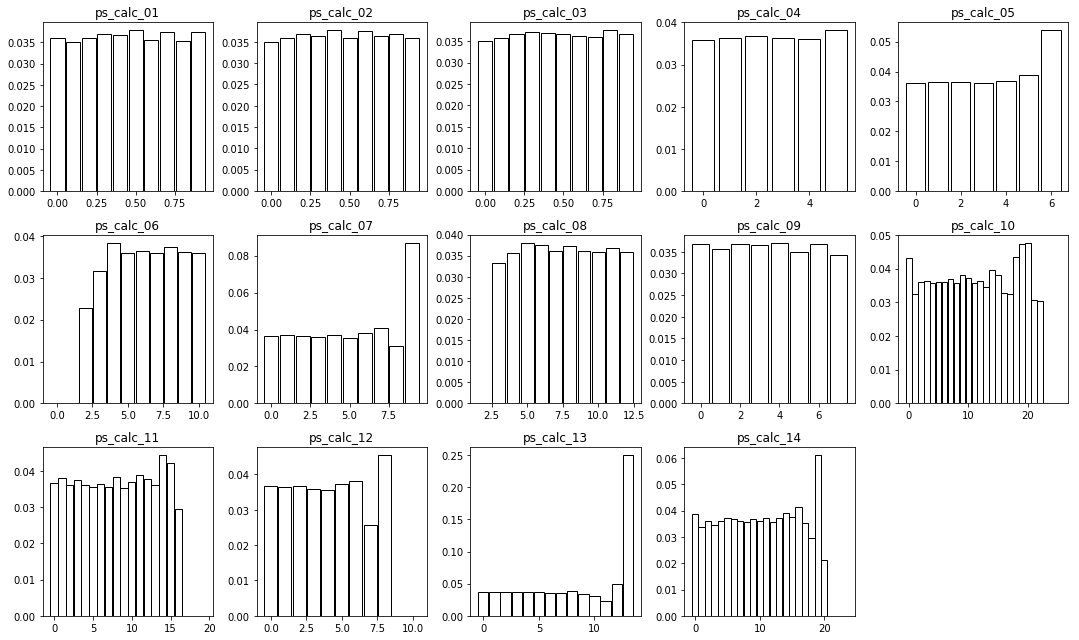

In [16]:
y = train.target
fig = plt.figure(figsize=(15, 9))
for i, f in enumerate(calc_fs):
    ax = fig.add_subplot(3, 5, i+1)
    result = estimate_cond_prob_density(others_calc[f], y, printout=False, output=True)
    x = result.iloc[:,0]
    h = result.iloc[:,1]
    w = (np.max(x) - np.min(x))/len(x)
    ax.bar(x, h, width=w, fill=False)
    ax.set_title('%s' % f)

plt.tight_layout()

<b><i>To be used: 'ps_calc_05'(low), 'ps_calc_07' (low), 'ps_calc_13' (high), and 'ps_calc_14' (low)</i></b>

<b>'others_car' features</b>

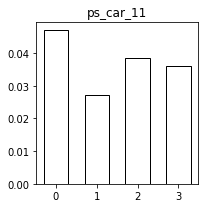

In [17]:
y = train.target
fig = plt.figure(figsize=(3, 3))
for i, f in enumerate(['ps_car_11']):
    ax = fig.add_subplot(1, 1, i+1)
    result = estimate_cond_prob_density(others_car[f], y, printout=False, output=True)
    x = result.iloc[:,0]
    h = result.iloc[:,1]
    w = (np.max(x) - np.min(x))/len(x)
    ax.bar(x, h, width=w, fill=False)
    ax.set_title('%s' % f)

plt.tight_layout()

<b>'others_ind' features</b>

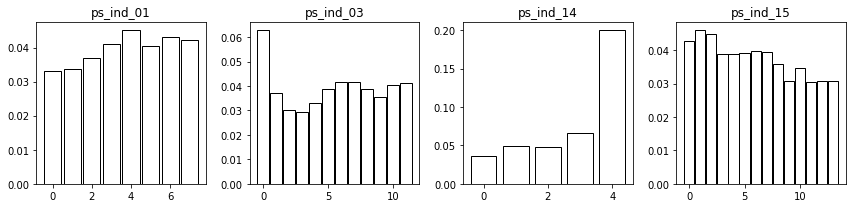

In [18]:
y = train.target
fig = plt.figure(figsize=(12, 3))
for i, f in enumerate(ind_fs):
    ax = fig.add_subplot(1, 4, i+1)
    result = estimate_cond_prob_density(others_ind[f], y, printout=False, output=True)
    x = result.iloc[:,0]
    h = result.iloc[:,1]
    w = (np.max(x) - np.min(x))/len(x)
    ax.bar(x, h, width=w, fill=False)
    ax.set_title('%s' % f)

plt.tight_layout()

<b><i>To be used: 'ps_ind_03'(low), 'ps_ind_14' (high)</i></b>

<b>'others_reg' features</b>

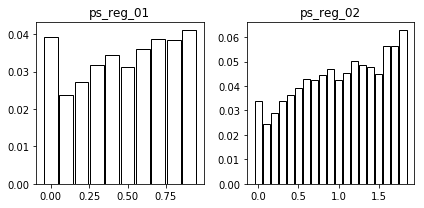

In [19]:
y = train.target
fig = plt.figure(figsize=(6, 3))
for i, f in enumerate(['ps_reg_01', 'ps_reg_02']):
    ax = fig.add_subplot(1, 2, i+1)
    result = estimate_cond_prob_density(others_reg[f], y, printout=False, output=True)
    x = result.iloc[:,0]
    h = result.iloc[:,1]
    w = (np.max(x) - np.min(x))/len(x)
    ax.bar(x, h, width=w, fill=False)
    ax.set_title('%s' % f)

plt.tight_layout()

<b><i>To be used: 'ps_reg_02'(linear relationship)</i></b>

## All to-be-used so far
- 'ps_calc_05'(low), 'ps_calc_07' (low), 'ps_calc_13' (high), and 'ps_calc_14' (low)
- 'ps_ind_03'(low), 'ps_ind_14' (high)
- 'ps_reg_02'(linear relationship)

## Take a look at truly continuous features

In [20]:
continuous_fs = ['ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_reg_03']
continuous = train[continuous_fs].replace({-1: np.NaN})
continuous = continuous.dropna()

<b>'ps_car_12' conditional prob distribution</b>

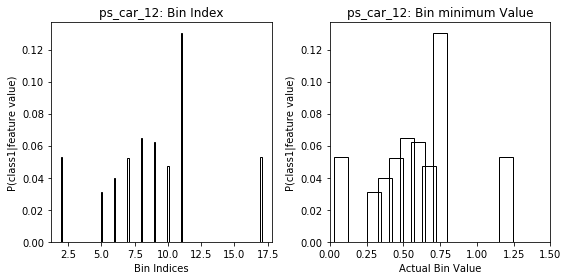

In [21]:
X = train[['ps_car_12', 'target']].replace({-1:np.NaN}).dropna()

binned_inds, binned_f = bin_myFeature(X.iloc[:, 0], 0, 1.5, bins=20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
result1 = estimate_cond_prob_density(binned_inds, X.iloc[:, 1], printout=False, output=True)
x1 = result1.iloc[:,0]
h1 = result1.iloc[:,1]
w1 = (np.max(x1) - np.min(x1))/len(x1)
ax1.bar(x1, h1, width=w, fill=False)
ax1.set_title('ps_car_12: Bin Index')
ax1.set_xlabel('Bin Indices')
ax1.set_ylabel('P(class1|feature value)')

result2 = estimate_cond_prob_density(binned_f, X.iloc[:, 1], printout=False, output=True)
x2 = result2.iloc[:,0]
h2 = result2.iloc[:,1]
w2 = (np.max(x2) - np.min(x1))/len(x2)
ax2.bar(x2, h2, width=w, fill=False)
ax2.set_title('ps_car_12: Bin minimum Value')
ax2.set_xlabel('Actual Bin Value')
ax2.set_ylabel('P(class1|feature value)')
ax2.set_xlim([0, 1.5])

plt.tight_layout()

The bin around 0.75 seems pretty useful

<b>'ps_car_13' conditional prob distribution</b>

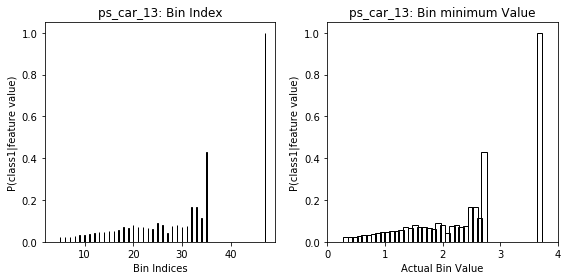

In [22]:
X = train[['ps_car_13', 'target']].replace({-1:np.NaN}).dropna()

binned_inds, binned_f = bin_myFeature(X.iloc[:, 0], 0, 4, bins=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
result1 = estimate_cond_prob_density(binned_inds, X.iloc[:, 1], printout=False, output=True)
x1 = result1.iloc[:,0]
h1 = result1.iloc[:,1]
w1 = (np.max(x1) - np.min(x1))/len(x1)
ax1.bar(x1, h1, width=w, fill=False)
ax1.set_title('ps_car_13: Bin Index')
ax1.set_xlabel('Bin Indices')
ax1.set_ylabel('P(class1|feature value)')

result2 = estimate_cond_prob_density(binned_f, X.iloc[:, 1], printout=False, output=True)
x2 = result2.iloc[:,0]
h2 = result2.iloc[:,1]
w2 = (np.max(x2) - np.min(x1))/len(x2)
ax2.bar(x2, h2, width=w, fill=False)
ax2.set_title('ps_car_13: Bin minimum Value')
ax2.set_xlabel('Actual Bin Value')
ax2.set_ylabel('P(class1|feature value)')
ax2.set_xlim([0, 4])

plt.tight_layout()

The last two bins are quite usefull. It's not clear how many entries there are, but if the value falls in the last bin, the predictability of the entry being in class1 is amost 100%

<b>'ps_car_14' conditional prob distribution</b>

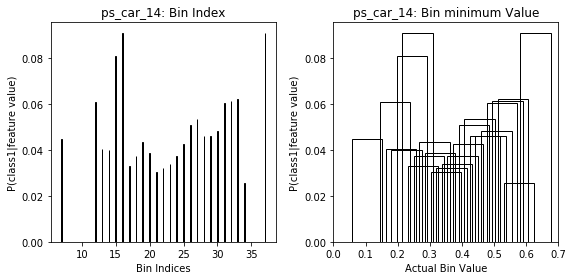

In [23]:
X = train[['ps_car_14', 'target']].replace({-1:np.NaN}).dropna()

binned_inds, binned_f = bin_myFeature(X.iloc[:, 0], 0, 0.7, bins=40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
result1 = estimate_cond_prob_density(binned_inds, X.iloc[:, 1], printout=False, output=True)
x1 = result1.iloc[:,0]
h1 = result1.iloc[:,1]
w1 = (np.max(x1) - np.min(x1))/len(x1)
ax1.bar(x1, h1, width=w, fill=False)
ax1.set_title('ps_car_14: Bin Index')
ax1.set_xlabel('Bin Indices')
ax1.set_ylabel('P(class1|feature value)')

result2 = estimate_cond_prob_density(binned_f, X.iloc[:, 1], printout=False, output=True)
x2 = result2.iloc[:,0]
h2 = result2.iloc[:,1]
w2 = (np.max(x2) - np.min(x1))/len(x2)
ax2.bar(x2, h2, width=w, fill=False)
ax2.set_title('ps_car_14: Bin minimum Value')
ax2.set_xlabel('Actual Bin Value')
ax2.set_ylabel('P(class1|feature value)')
ax2.set_xlim([0, 0.7])

plt.tight_layout()

Conditional probability values are all less than 0.1, This feature is probably not so useful compared to others.

<b>'ps_reg_03' conditional prob distribution</b>

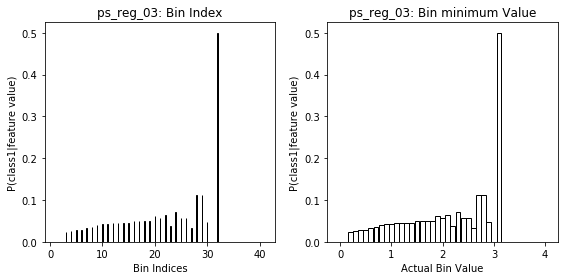

In [24]:
X = train[['ps_reg_03', 'target']].replace({-1:np.NaN}).dropna()

binned_inds, binned_f = bin_myFeature(X.iloc[:, 0], 0, 5, bins=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
result1 = estimate_cond_prob_density(binned_inds, X.iloc[:, 1], printout=False, output=True)
x1 = result1.iloc[:,0]
h1 = result1.iloc[:,1]
w1 = (np.max(x1) - np.min(x1))/len(x1)
ax1.bar(x1, h1, width=w, fill=False)
ax1.set_title('ps_reg_03: Bin Index')
ax1.set_xlabel('Bin Indices')
ax1.set_ylabel('P(class1|feature value)')

result2 = estimate_cond_prob_density(binned_f, X.iloc[:, 1], printout=False, output=True)
x2 = result2.iloc[:,0]
h2 = result2.iloc[:,1]
w2 = (np.max(x2) - np.min(x1))/len(x2)
ax2.bar(x2, h2, width=w, fill=False)
ax2.set_title('ps_reg_03: Bin minimum Value')
ax2.set_xlabel('Actual Bin Value')
ax2.set_ylabel('P(class1|feature value)')

plt.tight_layout()

Just like one of the features above, if the value falls in the last bin, the predictability of being in class1 is very high.

## To-be-used
- 'ps_car_12', 'ps_car_13' (prob not ps_car_14)
- 'ps_reg_03'

# Conclusion
Try using the feature categories and features in the following cells

In [25]:
print('-binary-\n', useful_binary, '\n')
print('-categorical1 (highest differential)-\n', useful_categorical1, '\n')
print('-categorical2 (medium1 differential)-\n', useful_categorical2, '\n')
print('-categorical3 (medium2 differential)-\n', useful_categorical3, '\n')
print('-categorical4 (low differential)-\n', useful_categorical4, '\n')
print('-categorical_neg (negative differential)-\n', useful_categorical_neg, '\n')

-binary-
 ['ps_ind_07_bin', 'ps_ind_10_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_17_bin'] 

-categorical1 (highest differential)-
 ['ps_car_04_cat_5', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_11_cat_18', 'ps_car_11_cat_41', 'ps_ind_05_cat_2'] 

-categorical2 (medium1 differential)-
 ['ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_04_cat_9', 'ps_car_06_cat_17', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_09_cat_1', 'ps_car_11_cat_18', 'ps_car_11_cat_21', 'ps_car_11_cat_4', 'ps_car_11_cat_41', 'ps_car_11_cat_58', 'ps_car_11_cat_63', 'ps_car_11_cat_75', 'ps_car_11_cat_93', 'ps_car_11_cat_97', 'ps_ind_05_cat_2', 'ps_ind_05_cat_6'] 

-categorical3 (medium2 differential)-
 ['ps_car_01_cat_9', 'ps_car_02_cat_0', 'ps_car_03_cat_1', 'ps_car_04_cat_3', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_04_cat_9', 'ps_car_06_cat_13', 'ps_car_06_cat_15', 'ps_car_06_cat_17', 'ps_car_06_cat_2', 'ps_

Semi-continuous/Oridnal ones and categories
- 'ps_calc_05'(low), 'ps_calc_07' (low), 'ps_calc_13' (high), and 'ps_calc_14' (low)
- 'ps_ind_03'(low), 'ps_ind_14' (high)
- 'ps_reg_02'(linear relationship)

Continuous ones
- 'ps_car_12', 'ps_car_13' (prob not ps_car_14)
- 'ps_reg_03'